# Locate peak on 2-D area detector image

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

TODO:

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Tue-21:59:04 - ############################################################ startup
I Tue-21:59:04 - logging started
I Tue-21:59:04 - logging level = 10
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Tue-21:59:04 - bluesky framework
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Tue-21:59:04 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Tue-21:59:05 - /home/mi

## Where _is_ everybody?

On the command line, there is an [IPython magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#built-in-magic-commands) command from the [bluesky](https://blueskyproject.io/bluesky/) package to print the current value of [labeled](https://blueskyproject.io/bluesky/magics.html?highlight=label) items: [`%wa`]()

In [2]:
%wa

area_detector
  Local variable name                    Ophyd name (to be recorded as metadata)
  adsimdet                               adsimdet                              

motor
  Positioner                     Value       Low Limit   High Limit  Offset     
  m1                             -0.7        -32000.0    32000.0     0.0        
  m10                            0.0         -32000.0    32000.0     0.0        
  m11                            0.0         -32000.0    32000.0     0.0        
  m12                            0.0         -32000.0    32000.0     0.0        
  m13                            0.0         -32000.0    32000.0     0.0        
  m14                            0.0         -32000.0    32000.0     0.0        
  m15                            0.0         -32000.0    32000.0     0.0        
  m16                            0.0         -32000.0    32000.0     0.0        
  m2                             0.0         -32000.0    32000.0     0.0        
  m3    

## **Who** is everybody?

Might be a good idea to know now what ophyd symbols are available.  The [apstools](https://apstools.readthedocs.io/en/latest/) package provides a [`listobjects()`](https://apstools.readthedocs.io/en/latest/source/_utils.html?highlight=listobjects#apstools.utils.listobjects) command that prints a table of all the known objects (in the global namespace of the session).  The columns provide the ophyd name (the name you use to call this in Python), the name of the ophyd structure, the EPICS PV (if relevant), and any labels (as used in `%wa` above).

Notably, the table includes:

* a simulated EPICS area detector (`adsimdet`), look for the `area_detector` label
* a simulated 16-channel EPICS scaler (`scaler1`), look for the `scalers` label
* some of the scaler channels are named (`I0`, `diode`, ...), look for the `counter` label
* a _noisy_ detector for use with motor `m1` to simulate a diffraction peak
* 16 simulated EPICS motors (`m1` .. `m16`), look for the `motor` label
* some calculation support (`calcs` & `calcouts`)
* a simulated shutter (`shutter`)
* a simulated temperature controller (`temperature`)
* details about the general purpose IOC (`gp_stats`)

In [3]:
listobjects()

=========== ================================ ============= =================
name        ophyd structure                  EPICS PV      label(s)         
=========== ================================ ============= =================
I0          EpicsSignalRO                    gp:scaler1.S2 counter channel  
adsimdet    MySimDetector                    ad:           area_detector    
calcouts    UserCalcoutDevice                gp:                            
calcs       UserCalcsDevice                  gp:                            
diode       EpicsSignalRO                    gp:scaler1.S4 counter channel  
gp_stats    IocInfoDevice                    gp:                            
m1          EpicsMotor                       gp:m1         motor            
m10         EpicsMotor                       gp:m10        motor            
m11         EpicsMotor                       gp:m11        motor            
m12         EpicsMotor                       gp:m12        motor            

## Let's work with the scaler

A scaler is a device that counts digital pulses from a pulse detector such
as a scintillation counter or from photodiodes or ionization chamber with
pulse chain electronics.  Scalers have
many channels, some of which might have no associated detector.  Our scaler
(`scaler1`) is a simulated device that records a random number of pulses in 
each channel.  We are only interested in the channels that have names provided
by users in the GUI screens.  In this screen for our scaler, only a few of the
channels are named:

![`scaler` GUI](resources/scaler.png "`scaler1` GUI")

Let's configure `scaler1` to report only the `diode` and `I0` channels (plus the count time channel which will *always* be included).  Keep in mind that the argument to this function is a Python list, so the channel names must be enclosed with `[]`.  The function does not return a result.  If something *is* printed, there is an error to be fixed.

NOTE:  To report _all_ named channels again, call the same function with argument in the parentheses.

In [4]:
scaler1.select_channels(["diode", "I0"])

The _easiest_ way to count the `scaler` object is to use the [`%ct`](https://blueskyproject.io/bluesky/magics.html?highlight=label#taking-a-reading-using-ct-post-v1-3-0) bluesky magic command, which counts all objects with the `detectors` label.

Note that the various magic commands are only available from the command line, not for use in a bluesky plan function.

In [5]:
%ct

[This data will not be saved. Use the RunEngine to collect data.]
noisy                          257.1714913832913
I0                             9.0
diode                          10.0
scaler1_time                   2.1


Compare with the reading when _all_ channels are selected:

In [6]:
scaler1.select_channels()
%ct

[This data will not be saved. Use the RunEngine to collect data.]
noisy                          257.1714913832913
timebase                       21000000.0
I0                             10.0
scint                          11.0
diode                          10.0
scaler1_time                   2.1


Now, select just the two channels again before continuing:

In [7]:
scaler1.select_channels(["diode", "I0"])

As noted before, the `%ct` command is only available from the command shell.

### use ophyd to count the scaler

We should learn how to use the underlying Python code to do the same steps.

The first step is to use pure ophyd methods to count and report, then use a bluesky plan to do the same thing.  The ophyd methods are `trigger`, `wait`, and `read`.  The `trigger` and `wait` methods can be chained together:

In [8]:
scaler1.trigger().wait()

Technically, we should `stage` and `unstage` the object.  **We'll use staging to control the count time of the scaler.**

The ophyd [`.stage()` method](https://nsls-ii.github.io/ophyd/generated/ophyd.device.BlueskyInterface.stage.html?highlight=stage#ophyd.device.BlueskyInterface.stage) prepares the object for its `.trigger()` method, while the `.unstage()` method returns the object's settings to the previous state before the `.stage()` method was called.

In [9]:
scaler1.stage()
scaler1.trigger().wait()
scaler1.unstage()

[Channels(prefix='gp:scaler1', name='scaler1_channels', parent='scaler1', read_attrs=['chan02', 'chan02.s', 'chan04', 'chan04.s'], configuration_attrs=['chan02', 'chan02.chname', 'chan02.preset', 'chan02.gate', 'chan04', 'chan04.chname', 'chan04.preset', 'chan04.gate']),
 ScalerCH(prefix='gp:scaler1', name='scaler1', read_attrs=['channels', 'channels.chan02', 'channels.chan02.s', 'channels.chan04', 'channels.chan04.s', 'time'], configuration_attrs=['channels', 'channels.chan02', 'channels.chan02.chname', 'channels.chan02.preset', 'channels.chan02.gate', 'channels.chan04', 'channels.chan04.chname', 'channels.chan04.preset', 'channels.chan04.gate', 'count_mode', 'delay', 'auto_count_delay', 'freq', 'preset_time', 'auto_count_time', 'egu'])]

Let's find out what happens when `scaler1` is staged.  That's controlled by the contents of a Python dictionary `.stage_sigs`:

In [10]:
scaler1.stage_sigs

OrderedDict()

It's empty, so nothing has been preconfigured for us.  Let's make sure that we get to pick the *counting time* (the time to accumulate pulses in the various channels), say 2.0 seconds, when we count here.

In [11]:
scaler1.stage_sigs["preset_time"] = 2
scaler1.stage_sigs

OrderedDict([('preset_time', 2)])

Show the counting time *before* we count, then `stage`, `trigger`, `wait`, `read`, `unstage`, then finally show the counting time  *after* we count:

In [12]:
print(f"Scaler configured to count for {scaler1.preset_time.get()}s")
scaler1.stage()
scaler1.trigger().wait()
print(scaler1.read())
scaler1.unstage()
print(f"Scaler configured to count for {scaler1.preset_time.get()}s")

Scaler configured to count for 2.0s
OrderedDict([('I0', {'value': 9.0, 'timestamp': 1614139165.298018}), ('diode', {'value': 9.0, 'timestamp': 1614139165.298018}), ('scaler1_time', {'value': 2.1, 'timestamp': 1614139162.958578})])
Scaler configured to count for 2.0s


The report from `.read()` includes both values and timestamps (in seconds since the Python [time](https://docs.python.org/3/library/time.html) epoch, UTC).  The structure is a Python dictionary.  This is the low-level method used to collect readings from any ophyd device.  We had to `print()` this since the return result from a command within a sequence is not returned at the end of the sequence, just the return result of the *final* command in the sequence.

See that the scaler counted for 2.1 seconds (a small bug in the scaler simulator it seems, always adds .1 to the count time!).  But before staging, the scaler was configured for 1.0 seconds, and after unstaging, the scaler returned to that value.

**That's how to control the counting time *for a scaler*.**  (Area detectors use different terms.  More on that later.)

<details>
    <summary>about <tt>scaler1_time</tt></summary>

     Of note is the key `scaler1_time` which is the name of the ophyd symbol `scaler1.time` as returned by `scaler1.time.name`:

        In [21]: scaler1.time.name
        Out [21]: 'scaler1_time'

</details>

### use bluesky (the package) to count the scaler

Now, use the bluesky [RunEngine](https://blueskyproject.io/bluesky/generated/bluesky.run_engine.RunEngine.html?highlight=runengine#bluesky.run_engine.RunEngine) (`RE`) to count `scaler1`.  We'll use the bluesky plan ([`bp`](https://blueskyproject.io/bluesky/plans.html?highlight=count#pre-assembled-plans)) called [`count()`](https://blueskyproject.io/bluesky/generated/bluesky.plans.count.html#bluesky.plans.count).  To be consistent with the result returned from `%ct`, we'll include the `noisy` detector.

In [13]:
RE(bp.count([scaler1,noisy]))



Transient Scan ID: 198     Time: 2021-02-23 21:59:25
Persistent Unique Scan ID: '903f01bf-377e-4f4b-b278-22f599875668'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+------------+
|   seq_num |       time |      noisy |         I0 |      diode |
+-----------+------------+------------+------------+------------+
|         1 | 21:59:28.2 |  257.17149 |         12 |         12 |
+-----------+------------+------------+------------+------------+
generator count ['903f01bf'] (scan num: 198)


('903f01bf-377e-4f4b-b278-22f599875668',)

There are many ways to view data from bluesky runs.  We'll pick one simple way, as a [dask](https://dask.org/) table since it is easy to display such structured content in a Jupyter notebook.

In [14]:
db.v2[-1].primary.to_dask()

<xarray.Dataset>
Dimensions:                                 (time: 1)
Coordinates:
  * time                                    (time) float64 1.614e+09
Data variables:
    noisy                                   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    I0                                      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    diode                                   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    scaler1_time                            (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    noisy:noisy                             (time) float64 257.2
    scaler1:scaler1_channels_chan02_chname  (time) <U2 'I0'
    scaler1:scaler1_channels_chan02_preset  (time) float64 0.0
    scaler1:scaler1_channels_chan02_gate    (time) <U1 'N'
    scaler1:scaler1_channels_chan04_chname  (time) <U5 'diode'
    scaler1:scaler1_channels_chan04_preset  (time) float64 0.0
    scaler1:scaler1_channels_chan04_gate    (time) <U1 'N'
    scaler1:scaler1_count_mode              (time) <U7 'OneShot'
    scaler1:scaler1_delay                   (time) float64 0.0
    scaler1:scaler1_auto_count_delay        (time) float64 0.0
    scaler1:scaler1_freq                    (time) float64 1e+07
    scaler1:scaler1_preset_time             (time) float64 2.0
    scaler1:scaler1_auto_count_time         (time) float64 1.0
    scaler1:scaler1_egu                     (time) <U1 ''
    seq_num                                 (time) int64 1
    uid                                     (time) <U36 'e06084a6-0814-4422-9...

As a last action in this section, use the [`listruns()`](https://apstools.readthedocs.io/en/latest/source/_utils.html?highlight=listobjects#apstools.utils.listruns) command from *apstools* to show the (default: 20) most recent runs in the database.  The table shows a short version of the run's unique identifier (`short_uid`), and other more obvious columns of information, truncated to avoid lengthy output.  The name of the [databroker *catalog*](https://blueskyproject.io/databroker/index.html) (`class_2021_03`) is shown before the table.

In [15]:
listruns()

catalog name: class_2021_03
========= ========================== ======= ======= ========================================
short_uid date/time                  exit    scan_id command                                 
========= ========================== ======= ======= ========================================
903f01b   2021-02-23 21:59:25.340877 success 198     count(detectors=['scaler1', 'noisy'] ...
66a69a7   2021-02-23 18:32:31.576462 success 197     count(detectors=['adsimdet'], num=1)    
d9b0f9d   2021-02-23 18:32:26.289070 success 196     rel_scan(detectors=['noisy'], num=23 ...
9e6e9a3   2021-02-23 18:32:22.471083 success 195     rel_scan(detectors=['noisy'], num=23 ...
9985e83   2021-02-23 18:32:15.630490 success 194     rel_scan(detectors=['noisy'], num=23 ...
38153cd   2021-02-23 18:31:57.382469 success 193     rel_scan(detectors=['noisy'], num=23 ...
3d8683f   2021-02-23 18:31:52.860667 success 192     rel_scan(detectors=['noisy'], num=23 ...
cf5c5ef   2021-02-23 18:31:48.41

## temperature _v_ time

work-in-progress

In [16]:
temperature.position

25.285519188220036

In [17]:
temperature.get()

MyPvPositionerTuple(setpoint=25.0, readback=25.285519188220036, done=True, calculation='A+max(-D,min(D,(B-A)))+C*(RNDM-0.5)', description='temperature', max_change=2.0, noise=1.0, previous_value_pv='gp:userCalc8.VAL', scanning_rate=5, tolerance=1.0, report_dmov_changes=False)

In [18]:
temperature.readback.get()

25.285519188220036

In [19]:
temperature.position

25.285519188220036

In [20]:
temperature.read()

OrderedDict([('temperature_setpoint',
              {'value': 25.0, 'timestamp': 1614139152.978289}),
             ('temperature_readback',
              {'value': 25.285519188220036, 'timestamp': 1614139169.130373}),
             ('temperature_done',
              {'value': True, 'timestamp': 1614139169.2098496}),
             ('temperature_calculation',
              {'value': 'A+max(-D,min(D,(B-A)))+C*(RNDM-0.5)',
               'timestamp': 1614139152.982938}),
             ('temperature_description',
              {'value': 'temperature', 'timestamp': 1614139152.97809}),
             ('temperature_max_change',
              {'value': 2.0, 'timestamp': 1614139152.982721}),
             ('temperature_noise',
              {'value': 1.0, 'timestamp': 1614139152.978799}),
             ('temperature_previous_value_pv',
              {'value': 'gp:userCalc8.VAL', 'timestamp': 1614139152.977478}),
             ('temperature_scanning_rate',
              {'value': 5, 'timestamp': 16141391

In [21]:
listdevice(temperature)

============================= =================================== ==========================
name                          value                               timestamp                 
============================= =================================== ==========================
temperature_setpoint          25.0                                2021-02-23 21:59:12.978289
temperature_readback          25.285519188220036                  2021-02-23 21:59:29.130373
temperature_done              True                                2021-02-23 21:59:29.209850
temperature_calculation       A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2021-02-23 21:59:12.982938
temperature_description       temperature                         2021-02-23 21:59:12.978090
temperature_max_change        2.0                                 2021-02-23 21:59:12.982721
temperature_noise             1.0                                 2021-02-23 21:59:12.978799
temperature_previous_value_pv gp:userCalc8.VAL                    2021

In [22]:
RE(bp.count([scaler1,noisy,temperature]))



Transient Scan ID: 199     Time: 2021-02-23 21:59:30
Persistent Unique Scan ID: '7cdcc9ac-6079-496e-9aab-9173638f497f'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+------------+----------------------+
|   seq_num |       time |      noisy |         I0 |      diode | temperature_readback |
+-----------+------------+------------+------------+------------+----------------------+
|         1 | 21:59:33.2 |  257.17149 |         10 |         11 |             25.36728 |
+-----------+------------+------------+------------+------------+----------------------+
generator count ['7cdcc9ac'] (scan num: 199)


('7cdcc9ac-6079-496e-9aab-9173638f497f',)



Transient Scan ID: 200     Time: 2021-02-23 21:59:33
Persistent Unique Scan ID: '6023c17e-893d-4fd5-b193-54e72a037898'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+------------+----------------------+
|   seq_num |       time |      noisy |         I0 |      diode | temperature_readback |
+-----------+------------+------------+------------+------------+----------------------+
|         1 | 21:59:36.8 |  257.17149 |         11 |          9 |             24.93650 |
|         2 | 21:59:39.7 |  257.17149 |         10 |         13 |             24.50104 |
|         3 | 21:59:42.6 |  257.17149 |         10 |         10 |             25.43729 |
|         4 | 21:59:45.3 |  257.17149 |          9 |         11 |             24.59349 |
|         5 | 21:59:48.1 |  257.17149 |         11 |         11 |             25.13526 |
+-----------+------------+------------+------------+------------+----------------------+
generator count ['6023c17e'] (sca

('6023c17e-893d-4fd5-b193-54e72a037898',)

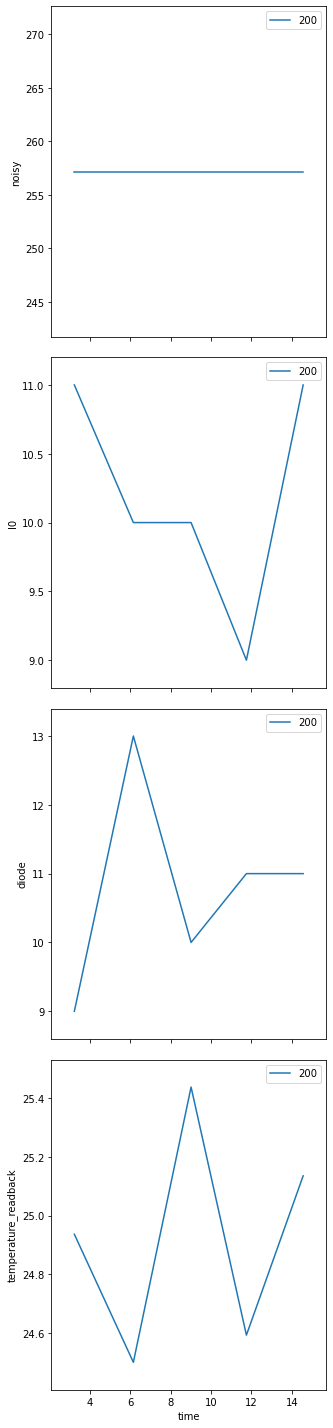

In [23]:
RE(bp.count([scaler1,noisy,temperature], num=5))



Transient Scan ID: 201     Time: 2021-02-23 21:59:50
Persistent Unique Scan ID: '2f97daaa-9b2f-45e8-bec4-54c9d49be54d'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 21:59:50.9 |             24.60396 |
|         2 | 21:59:51.1 |             24.60396 |
|         3 | 21:59:51.1 |             25.23228 |
|         4 | 21:59:51.3 |             25.23228 |
|         5 | 21:59:51.4 |             25.23228 |
+-----------+------------+----------------------+
generator count ['2f97daaa'] (scan num: 201)


('2f97daaa-9b2f-45e8-bec4-54c9d49be54d',)

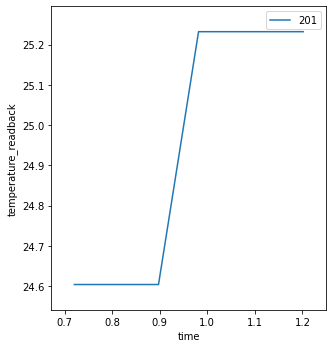

In [24]:
RE(bp.count([temperature], num=5))



Transient Scan ID: 202     Time: 2021-02-23 21:59:52
Persistent Unique Scan ID: 'a9b8152a-bdea-482f-ad15-a9490971bdf2'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 21:59:53.1 |             25.23228 |
|         2 | 21:59:54.8 |             25.35736 |
|         3 | 21:59:56.8 |             25.42476 |
|         4 | 21:59:58.8 |             25.03921 |
|         5 | 22:00:00.8 |             24.62479 |
+-----------+------------+----------------------+
generator count ['a9b8152a'] (scan num: 202)


('a9b8152a-bdea-482f-ad15-a9490971bdf2',)

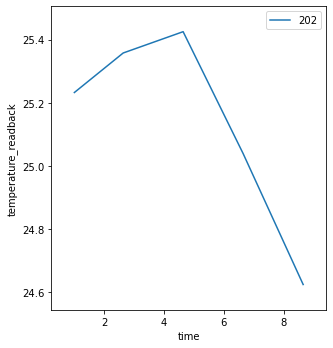

In [25]:
RE(bp.count([temperature], num=5, delay=2))



Transient Scan ID: 203     Time: 2021-02-23 22:00:03
Persistent Unique Scan ID: 'd93fef2a-52be-4872-8e8e-7b35494e4823'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+------------+
|   seq_num |       time | temperature_readback |      noisy |
+-----------+------------+----------------------+------------+
|         1 | 22:00:05.4 |             24.66487 |  257.17149 |
|         2 | 22:00:07.1 |             26.24290 |  257.17149 |
|         3 | 22:00:09.1 |             27.33917 |  257.17149 |
|         4 | 22:00:11.1 |             28.15705 |  257.17149 |
|         5 | 22:00:13.1 |             29.15286 |  257.17149 |
|         6 | 22:00:15.1 |             29.82096 |  257.17149 |
|         7 | 22:00:17.1 |             30.88705 |  257.17149 |
|         8 | 22:00:19.1 |             32.06861 |  257.17149 |
|         9 | 22:00:21.1 |             32.92501 |  257.17149 |
|        10 | 22:00:23.1 |             33.84336 |  257.17149 |
|        11 | 2

('d93fef2a-52be-4872-8e8e-7b35494e4823',)

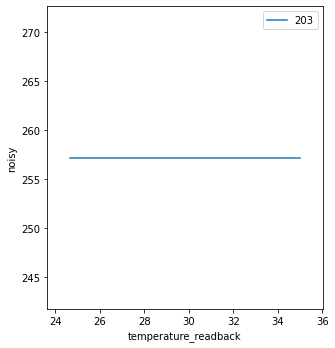

In [26]:
RE(bp.scan([noisy], temperature, 25, 35, 11))

In [27]:
%mov temperature 25


temperature:  24%|█████▊                  | 2.427/9.989 [00:01<00:03,  1.91C/s]
temperature:  43%|██████████▎             | 4.274/9.989 [00:03<00:04,  1.31C/s]
temperature:  67%|████████████████▏       | 6.729/9.989 [00:05<00:02,  1.28C/s]
temperature:  91%|█████████████████████▊  | 9.079/9.989 [00:07<00:00,  1.25C/s]
temperature [In progress. No progress bar available.]                          



In [28]:
temperature.position

25.909826810101475

In [29]:
%movr temperature 1


temperature: 100%|████████████████████████████| 1.0/1.0 [00:01<00:00,  1.87s/C]
temperature [In progress. No progress bar available.]                          



In [30]:
RE(bps.mv(temperature, 25))
temperature.position

24.948615243762877

In [31]:
RE(bps.mvr(temperature, 1))
temperature.position

25.8572823682002

## Find a peak: detector _v_ motor

work in progress

In [32]:
sd.monitors.append(temperature)



Transient Scan ID: 204     Time: 2021-02-23 22:00:40
Persistent Unique Scan ID: '0d3bab21-e766-4ce6-8a3e-1f2bfda1b895'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 22:00:43.3 |   -2.00000 |   11.81458 |
|         2 | 22:00:43.9 |   -1.82000 |   17.19166 |
|         3 | 22:00:44.3 |   -1.64000 |   25.84761 |
|         4 | 22:00:44.7 |   -1.45000 |   49.38975 |
|         5 | 22:00:45.2 |   -1.27000 |  113.85243 |
|         6 | 22:00:45.6 |   -1.09000 |  488.88347 |
|         7 | 22:00:46.0 |   -0.91000 | 31922.31468 |
|         8 | 22:00:46.4 |   -0.73000 |  353.04445 |
|         9 | 22:00:46.9 |   -0.55000 |   92.27527 |
|        10 | 22:00:47.4 |   -0.36000 |   41.61284 |
|        11 | 22:00:47.9 |   -0.18000 |   24.31699 |
|        12 | 22:00:48.3 |    0.00000 |   15.86421 |
|   

('0d3bab21-e766-4ce6-8a3e-1f2bfda1b895',
 '3f2931a4-6d41-47a8-880b-f954994abba1')

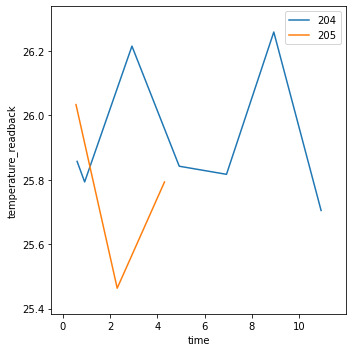

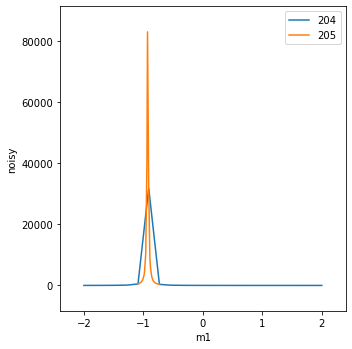

In [33]:
RE(example1())



Transient Scan ID: 206     Time: 2021-02-23 22:01:05
Persistent Unique Scan ID: 'd575dfd7-b402-4bfe-a4c5-e00ccf18f471'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 22:01:08.7 |   -2.10000 |    9.49880 |
|         2 | 22:01:09.3 |   -1.91000 |   13.64397 |
|         3 | 22:01:09.8 |   -1.72000 |   20.94079 |
|         4 | 22:01:10.4 |   -1.53000 |   37.29921 |
|         5 | 22:01:10.9 |   -1.34000 |   76.37092 |
|         6 | 22:01:11.4 |   -1.15000 |  270.04531 |
|         7 | 22:01:11.9 |   -0.95000 | 19420.04894 |
|         8 | 22:01:12.4 |   -0.76000 |  490.92660 |
|         9 | 22:01:12.9 |   -0.57000 |  106.33859 |
|        10 | 22:01:13.4 |   -0.38000 |   44.39000 |
|        11 | 22:01:13.9 |   -0.19000 |   24.38516 |
|        12 | 22:01:14.4 |    0.00000 |   15.35099 |
|   

('d575dfd7-b402-4bfe-a4c5-e00ccf18f471',
 '0d8e9136-0950-4041-bb43-69e2f75cda6f',
 '1edd5fb7-3fb8-4596-b76b-05ad0fa2c252',
 '69303026-dde6-41c9-8bfb-7ba30563440e')

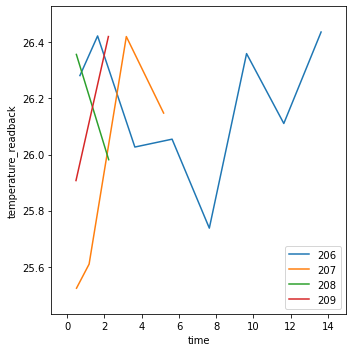

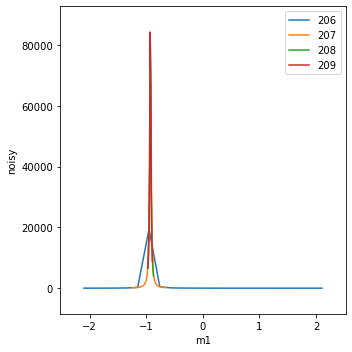

In [34]:
RE(example_findpeak())



Transient Scan ID: 210     Time: 2021-02-23 22:01:40
Persistent Unique Scan ID: '9be412e2-aa7f-4618-8fc1-ca2f498fafb1'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 22:01:43.7 |   -2.10000 |    1.42711 |
|         2 | 22:01:44.3 |   -1.91000 |    1.67578 |
|         3 | 22:01:44.9 |   -1.72000 |    2.01035 |
|         4 | 22:01:45.5 |   -1.53000 |    2.54940 |
|         5 | 22:01:46.0 |   -1.34000 |    3.27802 |
|         6 | 22:01:46.5 |   -1.15000 |    4.35498 |
|         7 | 22:01:47.0 |   -0.95000 |    5.86707 |
|         8 | 22:01:47.6 |   -0.76000 |    8.80996 |
|         9 | 22:01:48.2 |   -0.57000 |   14.48846 |
|        10 | 22:01:48.8 |   -0.38000 |   26.55419 |
|        11 | 22:01:49.3 |   -0.19000 |   67.46138 |
|        12 | 22:01:49.8 |    0.00000 |  362.52638 |
|    

('9be412e2-aa7f-4618-8fc1-ca2f498fafb1',
 '0513f337-61c9-48f1-97ea-41b82b25723b',
 '238dd224-f101-4432-899e-d994c8adc374',
 'd406d512-a5a8-4032-9aa0-144d6291f39f')

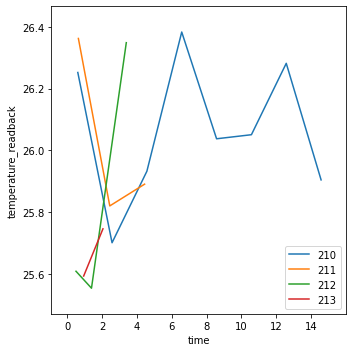

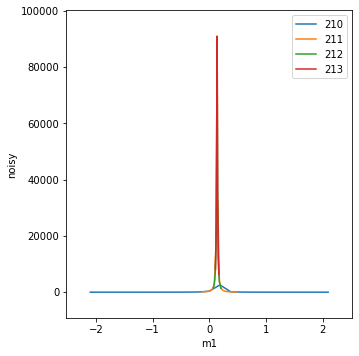

In [35]:
RE(repeat_findpeak())

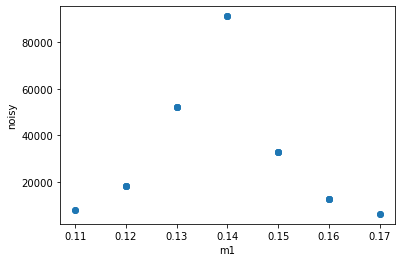

In [36]:
ds = db.v2[-1].primary.read().plot.scatter(x="m1", y="noisy")

## Record an Image

work in progress



Transient Scan ID: 214     Time: 2021-02-23 22:02:19
Persistent Unique Scan ID: '65c2eb84-d542-4fec-8f59-b6673d127e7c'
New stream: 'baseline'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 22:02:20.3 |
+-----------+------------+
generator count ['65c2eb84'] (scan num: 214)


('65c2eb84-d542-4fec-8f59-b6673d127e7c',)

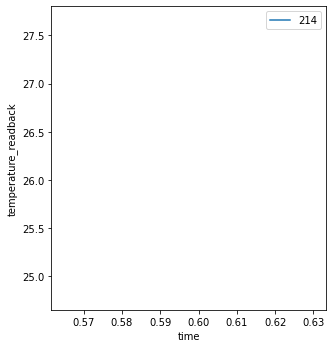

In [37]:
RE(bp.count([adsimdet]))

In [38]:
run = db.v2[-1]

In [39]:
run.metadata

{'start': Start({'beamline_id': 'APS_Python_training_2021',
 'detectors': ['adsimdet'],
 'hints': {'dimensions': [[['time'], 'primary']]},
 'instrument_name': 'class_2021_03',
 'login_id': 'mintadmin@mint-vm',
 'num_intervals': 0,
 'num_points': 1,
 'pid': 9931,
 'plan_args': {'detectors': ["MySimDetector(prefix='ad:', name='adsimdet', "
                             "read_attrs=[], configuration_attrs=['cam', "
                             "'cam.acquire_period', 'cam.acquire_time', "
                             "'cam.image_mode', 'cam.manufacturer', "
                             "'cam.model', 'cam.num_exposures', "
                             "'cam.num_images', 'cam.trigger_mode'])"],
               'num': 1},
 'plan_name': 'count',
 'plan_type': 'generator',
 'proposal_id': 'training',
 'scan_id': 214,
 'time': 1614139339.3187203,
 'uid': '65c2eb84-d542-4fec-8f59-b6673d127e7c',
 'versions': {'apstools': '1.4.0+1.g50c6f9d',
              'bluesky': '1.6.7',
              'databroker

In [40]:
# TODO: https://blueskyproject.io/databroker/tutorials/get-data.html?highlight=image
ds = run.primary.to_dask()

In [41]:
# FIXME: Where is the image data?
ds

<xarray.Dataset>
Dimensions:                               (time: 1)
Coordinates:
  * time                                  (time) float64 1.614e+09
Data variables:
    adsimdet:adsimdet_cam_acquire_period  (time) float64 0.105
    adsimdet:adsimdet_cam_acquire_time    (time) float64 0.1
    adsimdet:adsimdet_cam_image_mode      (time) int64 0
    adsimdet:adsimdet_cam_manufacturer    (time) <U18 'Simulated detector'
    adsimdet:adsimdet_cam_model           (time) <U15 'Basic simulator'
    adsimdet:adsimdet_cam_num_exposures   (time) int64 1
    adsimdet:adsimdet_cam_num_images      (time) int64 1
    adsimdet:adsimdet_cam_trigger_mode    (time) int64 0
    seq_num                               (time) int64 1
    uid                                   (time) <U36 '5b21fa04-92aa-4a65-a4f...

In [42]:
ds = run.primary.read()
ds

<xarray.Dataset>
Dimensions:                               (time: 1)
Coordinates:
  * time                                  (time) float64 1.614e+09
Data variables:
    adsimdet:adsimdet_cam_acquire_period  (time) float64 0.105
    adsimdet:adsimdet_cam_acquire_time    (time) float64 0.1
    adsimdet:adsimdet_cam_image_mode      (time) int64 0
    adsimdet:adsimdet_cam_manufacturer    (time) <U18 'Simulated detector'
    adsimdet:adsimdet_cam_model           (time) <U15 'Basic simulator'
    adsimdet:adsimdet_cam_num_exposures   (time) int64 1
    adsimdet:adsimdet_cam_num_images      (time) int64 1
    adsimdet:adsimdet_cam_trigger_mode    (time) int64 0
    seq_num                               (time) int64 1
    uid                                   (time) <U36 '5b21fa04-92aa-4a65-a4f...

----

---

[`%mov`](https://blueskyproject.io/bluesky/magics.html?highlight=label#moving-a-motor) (Magic command) : move a positioner